## Analysis of batch 309
* Compare task-modulation / gain in ON vs. OFF BF units.
* Compare these results with pupil-modulation (where there will presumably be no tuning dependence)
* 309 data include IC units recorded with pupil

### Procedure
* In scripts saved in `nems_db/nems_lbhb/pupil_behavior_scripts/` I did the following:
    * used Greg's STRF code to cache a BF for each recorded unit. I used all the data for this (i.e. I used all the data that went into the NEMS model)
    * performed a db query for each cell to look up the target freq for each recording file. I cached these as well.
    * I ran the following chunk of code in `pupil_behavior_dump_csv.py` to cache NEMS model results
```
state_list = ['st.pup0.fil0','st.pup0.fil','st.pup.fil0','st.pup.fil']
basemodel2 = "-ref-psthfr.s_sdexp.S"
loader = "psth.fs20.pup-ld-"
batches = [307, 309]
for batch in batches:
    d = get_model_results_per_state_model(batch=batch, state_list=state_list,
                                          basemodel=basemodel2, loader=loader)
    d.to_csv('d_'+str(batch)+'_pup_fil.csv')       
```

* Since all these results are cached in `nems_db`, this notebook should run just fine in any local python environment where you've pulled down the latest `nems_db

### Define path and import modules

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns

In [15]:
db_path = '/auto/users/hellerc/code/nems_db/'

### Define global analysis params

In [16]:
batch = 309
cutoff = 0.5   # octaves from target freq to be considered ON BF
sdexp = False   # if false, use stategain

In [17]:
# load model results data
if not sdexp:
    dMI = pd.read_csv(db_path+'nems_lbhb/pupil_behavior_scripts/d_{}_pup_fil_stategain.csv'.format(batch), index_col=0)
else:
    dMI = pd.read_csv(db_path+'nems_lbhb/pupil_behavior_scripts/d_{}_pup_fil.csv'.format(batch), index_col=0)
try:
    dMI['r'] = [np.float(r.strip('[]')) for r in dMI['r'].values]
    dMI['r_se'] = [np.float(r.strip('[]')) for r in dMI['r_se'].values]
except:
    pass

# get task model params / MI
file_merge = dMI[(dMI['state_sig']=='st.pup.fil') & (dMI['state_chan_alt'].str.contains('ACTIVE'))][['cellid', 'state_chan_alt', 'MI', 'g', 'd', 'r', 'r_se']].merge(\
                dMI[(dMI['state_sig']=='st.pup.fil0') & (dMI['state_chan_alt'].str.contains('ACTIVE'))][['cellid', 'state_chan_alt', 'MI', 'g', 'd', 'r', 'r_se']], \
                on=['cellid', 'state_chan_alt'])

file_merge['gain_task'] = file_merge['g_x']
file_merge['MI_task'] = file_merge['MI_x'] - file_merge['MI_y']
file_merge['dc_task'] = file_merge['d_x']

# get sig task cells
file_merge['sig_task'] = [True if ((file_merge.iloc[i]['r_x'] - file_merge.iloc[i]['r_y']) > 
                                        (file_merge.iloc[i]['r_se_x'] + file_merge.iloc[i]['r_se_y'])) else False for i in range(file_merge.shape[0])]

# strip extraneous columns
file_merge = file_merge.drop(columns=[c for c in file_merge.columns if ('_x' in c) | ('_y' in c)])

# get pupil model params / MI
pupil_merge = dMI[(dMI['state_sig']=='st.pup.fil') & (dMI['state_chan_alt']=='pupil')][['cellid', 'state_chan_alt', 'MI', 'g', 'd', 'r', 'r_se']].merge(\
                dMI[(dMI['state_sig']=='st.pup0.fil') & (dMI['state_chan_alt']=='pupil')][['cellid', 'state_chan_alt', 'MI', 'g', 'd', 'r', 'r_se']], \
                on=['cellid', 'state_chan_alt'])

pupil_merge['gain_pupil'] = pupil_merge['g_x']
pupil_merge['MI_pupil'] = pupil_merge['MI_x'] - pupil_merge['MI_y']
pupil_merge['dc_pupil'] = pupil_merge['d_x']

# get sig pupil cells
pupil_merge['sig_pupil'] = [True if ((pupil_merge.iloc[i]['r_x'] - pupil_merge.iloc[i]['r_y']) > 
                                        (pupil_merge.iloc[i]['r_se_x'] + pupil_merge.iloc[i]['r_se_y'])) else False for i in range(pupil_merge.shape[0])]

# strip extraneous columns
pupil_merge = pupil_merge.drop(columns=[c for c in pupil_merge.columns if ('_x' in c) | ('_y' in c)])
pupil_merge = pupil_merge.drop(columns=['state_chan_alt'])

# load BF / SNR data
dBF = pd.read_csv(db_path+'nems_lbhb/pupil_behavior_scripts/d_{}_tuning.csv'.format(batch), index_col=0)
dBF.index.name = 'cellid'

# load tar frequencies
dTF = pd.read_csv(db_path+'nems_lbhb/pupil_behavior_scripts/d_{}_tar_freqs.csv'.format(batch), index_col=0)

# merge results into single df for 307 and for 309
df = file_merge.merge(dTF, on=['cellid', 'state_chan_alt'])
df = df.merge(pupil_merge, on=['cellid'])
df.index = df.cellid
df = df.drop(columns=['cellid'])

df = df.merge(dBF, left_index=True, right_index=True)

# add column classifying octave sep. from target
df['oct_diff'] = abs(np.log2(df['tar_freq'] / df['BF']))

# add column for on cells / off cells
df['ON_BF'] = [True if df.iloc[i]['oct_diff']<=cutoff else False for i in range(df.shape[0])]
df['OFF_BF'] = [True if df.iloc[i]['oct_diff']>cutoff else False for i in range(df.shape[0])]

In [18]:
df.head()

,state_chan_alt,gain_task,MI_task,dc_task,sig_task,tar_freq,gain_pupil,MI_pupil,dc_pupil,sig_pupil,BF,SNR,oct_diff,ON_BF,OFF_BF
cellid,,,,,,,,,,,,,,,
BRT005c-a1,ACTIVE_1,0.002028,0.079396,0.100612,False,1000.0,-0.103372,-0.005922,-0.029071,False,2703.0,5.492757,1.434562,False,True
BRT005c-a1,ACTIVE_2,0.094857,0.120570,0.174242,False,1000.0,-0.103372,-0.005922,-0.029071,False,2703.0,5.492757,1.434562,False,True
BRT006d-a1,ACTIVE_1,-0.037882,-0.052399,-0.098925,False,2000.0,0.121867,-0.026117,-0.050296,False,1439.0,4.963518,0.474933,True,False
BRT006d-a1,ACTIVE_2,0.381905,-0.008020,-0.069094,False,2000.0,0.121867,-0.026117,-0.050296,False,1439.0,4.963518,0.474933,True,False
BRT006d-a2,ACTIVE_1,0.535201,0.059646,0.022927,False,2000.0,0.083299,-0.008646,-0.029939,False,3220.0,5.479147,0.687061,False,True


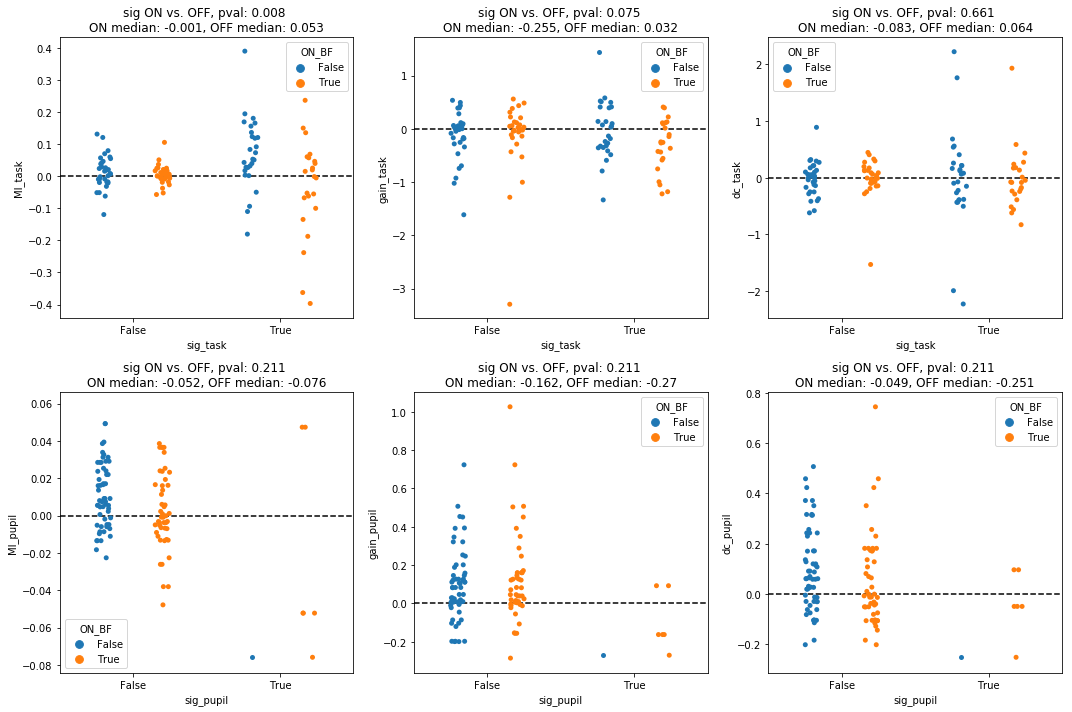

In [19]:
fix_ylims = False
data = df.copy()

f, ax = plt.subplots(2, 3, figsize=(15, 10))

# BEHAVIOR results
# MI
sns.stripplot(x='sig_task', y='MI_task', hue='ON_BF', data=data, dodge=True, ax=ax[0, 0])
ax[0, 0].axhline(0, linestyle='--', color='k')
pval = np.round(ss.ranksums(df[df['sig_task'] & df['ON_BF']]['MI_task'], df[df['sig_task'] & df['OFF_BF']]['MI_task']).pvalue, 3)
on_median = np.round(df[df['sig_task'] & df['ON_BF']]['MI_task'].median(), 3)
off_median = np.round(df[df['sig_task'] & df['OFF_BF']]['MI_task'].median(), 3)
ax[0, 0].set_title('sig ON vs. OFF, pval: {0} \n'
                    'ON median: {1}, OFF median: {2}'.format(pval, on_median, off_median))

# Gain
sns.stripplot(x='sig_task', y='gain_task', hue='ON_BF', data=data, dodge=True, ax=ax[0, 1])
ax[0, 1].axhline(0, linestyle='--', color='k')
pval = np.round(ss.ranksums(df[df['sig_task'] & df['ON_BF']]['gain_task'], df[df['sig_task'] & df['OFF_BF']]['gain_task']).pvalue, 3)
on_median = np.round(df[df['sig_task'] & df['ON_BF']]['gain_task'].median(), 3)
off_median = np.round(df[df['sig_task'] & df['OFF_BF']]['gain_task'].median(), 3)
ax[0, 1].set_title('sig ON vs. OFF, pval: {0} \n'
                    'ON median: {1}, OFF median: {2}'.format(pval, on_median, off_median))

# DC
sns.stripplot(x='sig_task', y='dc_task', hue='ON_BF', data=data, dodge=True, ax=ax[0, 2])
ax[0, 2].axhline(0, linestyle='--', color='k')
pval = np.round(ss.ranksums(df[df['sig_task'] & df['ON_BF']]['dc_task'], df[df['sig_task'] & df['OFF_BF']]['dc_task']).pvalue, 3)
on_median = np.round(df[df['sig_task'] & df['ON_BF']]['dc_task'].median(), 3)
off_median = np.round(df[df['sig_task'] & df['OFF_BF']]['dc_task'].median(), 3)
ax[0, 2].set_title('sig ON vs. OFF, pval: {0} \n'
                    'ON median: {1}, OFF median: {2}'.format(pval, on_median, off_median))

# PUPIL results
# MI
sns.stripplot(x='sig_pupil', y='MI_pupil', hue='ON_BF', data=data, dodge=True, ax=ax[1, 0])
ax[1, 0].axhline(0, linestyle='--', color='k')
pval = np.round(ss.ranksums(df[df['sig_pupil'] & df['ON_BF']]['MI_pupil'], df[df['sig_pupil'] & df['OFF_BF']]['MI_pupil']).pvalue, 3)
on_median = np.round(df[df['sig_pupil'] & df['ON_BF']]['MI_pupil'].median(), 3)
off_median = np.round(df[df['sig_pupil'] & df['OFF_BF']]['MI_pupil'].median(), 3)
ax[1, 0].set_title('sig ON vs. OFF, pval: {0} \n'
                    'ON median: {1}, OFF median: {2}'.format(pval, on_median, off_median))

# Gain
sns.stripplot(x='sig_pupil', y='gain_pupil', hue='ON_BF', data=data, dodge=True, ax=ax[1, 1])
ax[1, 1].axhline(0, linestyle='--', color='k')
pval = np.round(ss.ranksums(df[df['sig_pupil'] & df['ON_BF']]['gain_pupil'], df[df['sig_pupil'] & df['OFF_BF']]['gain_pupil']).pvalue, 3)
on_median = np.round(df[df['sig_pupil'] & df['ON_BF']]['gain_pupil'].median(), 3)
off_median = np.round(df[df['sig_pupil'] & df['OFF_BF']]['gain_pupil'].median(), 3)
ax[1, 1].set_title('sig ON vs. OFF, pval: {0} \n'
                    'ON median: {1}, OFF median: {2}'.format(pval, on_median, off_median))

# DC
sns.stripplot(x='sig_pupil', y='dc_pupil', hue='ON_BF', data=data, dodge=True, ax=ax[1, 2])
ax[1, 2].axhline(0, linestyle='--', color='k')
pval = np.round(ss.ranksums(df[df['sig_pupil'] & df['ON_BF']]['dc_pupil'], df[df['sig_pupil'] & df['OFF_BF']]['dc_pupil']).pvalue, 3)
on_median = np.round(df[df['sig_pupil'] & df['ON_BF']]['dc_pupil'].median(), 3)
off_median = np.round(df[df['sig_pupil'] & df['OFF_BF']]['dc_pupil'].median(), 3)
ax[1, 2].set_title('sig ON vs. OFF, pval: {0} \n'
                    'ON median: {1}, OFF median: {2}'.format(pval, on_median, off_median))

if fix_ylims:
    for a in [ax[0, 1], ax[0, 2], ax[1, 1], ax[1, 2]]:
        a.set_ylim((-2, 2))
        
f.tight_layout()

### Plot histogram of MI / gain / DC for task modulation

/auto/users/hellerc/anaconda3/envs/crh_nems/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Text(0.5,1,'on: -0.079, off: -0.097, \non_pval: 0.435, off_pval: 1.0')

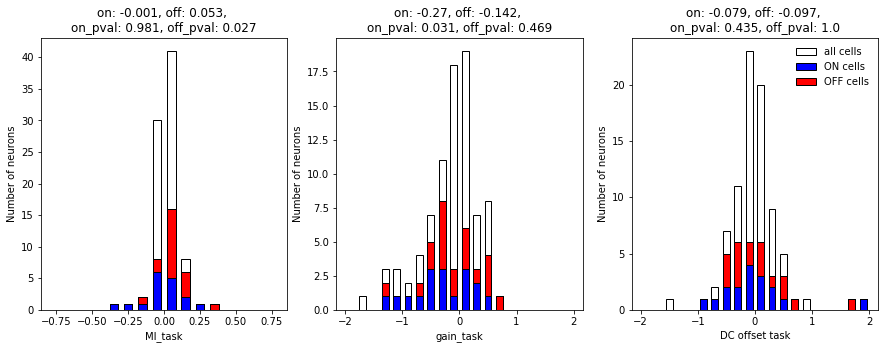

In [20]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))

mi_bins = np.arange(-.8, .9, 0.1)
ax[0].hist(df.groupby(by=['cellid', 'ON_BF']).mean()['MI_task'], 
           bins=mi_bins, color='white', edgecolor='k', rwidth=0.6, label='all cells')
ax[0].hist([df[df['sig_task'] & df['ON_BF']].groupby(by='cellid').mean()['MI_task'], 
            df[df['sig_task'] & df['OFF_BF']].groupby(by='cellid').mean()['MI_task']],
           color=['blue', 'red'], bins=mi_bins, edgecolor='k', rwidth=0.6, 
           label=['ON cells', 'OFF cells'], histtype='barstacked')
ax[0].set_xlabel('MI_task', fontsize=10)
ax[0].set_ylabel('Number of neurons', fontsize=10)

if not sdexp:
    gain_bins = np.arange(-2, 2.2, .2)
else:
    gain_bins = np.arange(-10, 11, 1)
ax[1].hist(df.groupby(by=['cellid', 'ON_BF']).mean()['gain_task'], 
           bins=gain_bins, color='white', edgecolor='k', rwidth=0.6, label='all cells')
ax[1].hist([df[df['sig_task'] & df['ON_BF']].groupby(by='cellid').mean()['gain_task'], 
            df[df['sig_task'] & df['OFF_BF']].groupby(by='cellid').mean()['gain_task']],
           color=['blue', 'red'], bins=gain_bins, edgecolor='k', rwidth=0.6, 
           label=['ON cells', 'OFF cells'], histtype='barstacked')
ax[1].set_xlabel('gain_task', fontsize=10)
ax[1].set_ylabel('Number of neurons', fontsize=10)

if not sdexp:
    dc_bins = np.arange(-2, 2.2, .2)
else:
    dc_bins = np.arange(-10, 11, 1)
ax[2].hist(df.groupby(by=['cellid', 'ON_BF']).mean()['dc_task'], 
           bins=dc_bins, color='white', edgecolor='k', rwidth=0.6, label='all cells')
ax[2].hist([df[df['sig_task'] & df['ON_BF']].groupby(by='cellid').mean()['dc_task'], 
            df[df['sig_task'] & df['OFF_BF']].groupby(by='cellid').mean()['dc_task']],
           color=['blue', 'red'], bins=dc_bins, edgecolor='k', rwidth=0.6, 
           label=['ON cells', 'OFF cells'], histtype='barstacked')
ax[2].set_xlabel('DC offset task', fontsize=10)
ax[2].set_ylabel('Number of neurons', fontsize=10)
ax[2].legend(frameon=False, fontsize=10)


# add stats

# MI
on_median = np.round(df[df['sig_task'] & df['ON_BF']].groupby(by='cellid').mean()['MI_task'].median(), 3)
on_pval = np.round(ss.wilcoxon(df[df['sig_task'] & df['ON_BF']].groupby(by='cellid').mean()['MI_task']).pvalue, 3)
off_median = np.round(df[df['sig_task'] & df['OFF_BF']].groupby(by='cellid').mean()['MI_task'].median(), 3)
off_pval = np.round(ss.wilcoxon(df[df['sig_task'] & df['OFF_BF']].groupby(by='cellid').mean()['MI_task']).pvalue, 3)
ax[0].set_title('on: {0}, off: {1}, \n'
                'on_pval: {2}, off_pval: {3}'.format(on_median, off_median, on_pval, off_pval))
# gain
on_median = np.round(df[df['sig_task'] & df['ON_BF']].groupby(by='cellid').mean()['gain_task'].median(), 3)
on_pval = np.round(ss.wilcoxon(df[df['sig_task'] & df['ON_BF']].groupby(by='cellid').mean()['gain_task']).pvalue, 3)
off_median = np.round(df[df['sig_task'] & df['OFF_BF']].groupby(by='cellid').mean()['gain_task'].median(), 3)
off_pval = np.round(ss.wilcoxon(df[df['sig_task'] & df['OFF_BF']].groupby(by='cellid').mean()['gain_task']).pvalue, 3)
ax[1].set_title('on: {0}, off: {1}, \n'
                'on_pval: {2}, off_pval: {3}'.format(on_median, off_median, on_pval, off_pval))

# DC
on_median = np.round(df[df['sig_task'] & df['ON_BF']].groupby(by='cellid').mean()['dc_task'].median(), 3)
on_pval = np.round(ss.wilcoxon(df[df['sig_task'] & df['ON_BF']].groupby(by='cellid').mean()['dc_task']).pvalue, 3)
off_median = np.round(df[df['sig_task'] & df['OFF_BF']].groupby(by='cellid').mean()['dc_task'].median(), 3)
off_pval = np.round(ss.wilcoxon(df[df['sig_task'] & df['OFF_BF']].groupby(by='cellid').mean()['dc_task']).pvalue, 3)
ax[2].set_title('on: {0}, off: {1}, \n'
                'on_pval: {2}, off_pval: {3}'.format(on_median, off_median, on_pval, off_pval))

### Plot histogram of MI, gain, DC for pupil

/home/hellerc/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:2385: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


Text(0.5,1,'on: -0.049, off: -0.251, \non_pval: 0.593, off_pval: 0.317')

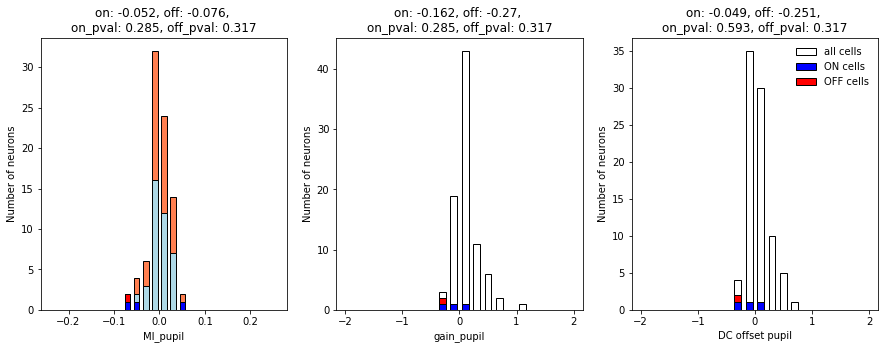

In [8]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))

mi_bins = np.arange(-.24, .28, 0.02)
ax[0].hist([df[df['ON_BF']].groupby(by=['cellid', 'ON_BF']).mean()['MI_pupil'], 
            df[df['ON_BF']].groupby(by=['cellid', 'OFF_BF']).mean()['MI_pupil']],
           bins=mi_bins, color=['lightblue', 'coral'], edgecolor='k', rwidth=0.6, label=['ON', 'OFF'], histtype='barstacked')
ax[0].hist([df[df['sig_pupil'] & df['ON_BF']].groupby(by='cellid').mean()['MI_pupil'], 
            df[df['sig_pupil'] & df['OFF_BF']].groupby(by='cellid').mean()['MI_pupil']],
           color=['blue', 'red'], bins=mi_bins, edgecolor='k', rwidth=0.6, 
           label=['ON cells', 'OFF cells'], histtype='barstacked')
ax[0].set_xlabel('MI_pupil', fontsize=10)
ax[0].set_ylabel('Number of neurons', fontsize=10)

if not sdexp:
    gain_bins = np.arange(-2, 2.2, .2)
else:
    gain_bins = np.arange(-10, 11, 1)
ax[1].hist(df.groupby(by=['cellid', 'ON_BF']).mean()['gain_pupil'], 
           bins=gain_bins, color='white', edgecolor='k', rwidth=0.6, label='all cells')
ax[1].hist([df[df['sig_pupil'] & df['ON_BF']].groupby(by='cellid').mean()['gain_pupil'], 
            df[df['sig_pupil'] & df['OFF_BF']].groupby(by='cellid').mean()['gain_pupil']],
           color=['blue', 'red'], bins=gain_bins, edgecolor='k', rwidth=0.6, 
           label=['ON cells', 'OFF cells'], histtype='barstacked')
ax[1].set_xlabel('gain_pupil', fontsize=10)
ax[1].set_ylabel('Number of neurons', fontsize=10)

if not sdexp:
    dc_bins = np.arange(-2, 2.2, .2)
else:
    dc_bins = np.arange(-10, 11, 1)
ax[2].hist(df.groupby(by=['cellid', 'ON_BF']).mean()['dc_pupil'], 
           bins=dc_bins, color='white', edgecolor='k', rwidth=0.6, label='all cells')
ax[2].hist([df[df['sig_pupil'] & df['ON_BF']].groupby(by='cellid').mean()['dc_pupil'], 
            df[df['sig_pupil'] & df['OFF_BF']].groupby(by='cellid').mean()['dc_pupil']],
           color=['blue', 'red'], bins=dc_bins, edgecolor='k', rwidth=0.6, 
           label=['ON cells', 'OFF cells'], histtype='barstacked')
ax[2].set_xlabel('DC offset pupil', fontsize=10)
ax[2].set_ylabel('Number of neurons', fontsize=10)
ax[2].legend(frameon=False, fontsize=10)


# add stats

# MI
on_median = np.round(df[df['sig_pupil'] & df['ON_BF']].groupby(by='cellid').mean()['MI_pupil'].median(), 3)
on_pval = np.round(ss.wilcoxon(df[df['sig_pupil'] & df['ON_BF']].groupby(by='cellid').mean()['MI_pupil']).pvalue, 3)
off_median = np.round(df[df['sig_pupil'] & df['OFF_BF']].groupby(by='cellid').mean()['MI_pupil'].median(), 3)
off_pval = np.round(ss.wilcoxon(df[df['sig_pupil'] & df['OFF_BF']].groupby(by='cellid').mean()['MI_pupil']).pvalue, 3)
ax[0].set_title('on: {0}, off: {1}, \n'
                'on_pval: {2}, off_pval: {3}'.format(on_median, off_median, on_pval, off_pval))
# gain
on_median = np.round(df[df['sig_pupil'] & df['ON_BF']].groupby(by='cellid').mean()['gain_pupil'].median(), 3)
on_pval = np.round(ss.wilcoxon(df[df['sig_pupil'] & df['ON_BF']].groupby(by='cellid').mean()['gain_pupil']).pvalue, 3)
off_median = np.round(df[df['sig_pupil'] & df['OFF_BF']].groupby(by='cellid').mean()['gain_pupil'].median(), 3)
off_pval = np.round(ss.wilcoxon(df[df['sig_pupil'] & df['OFF_BF']].groupby(by='cellid').mean()['gain_pupil']).pvalue, 3)
ax[1].set_title('on: {0}, off: {1}, \n'
                'on_pval: {2}, off_pval: {3}'.format(on_median, off_median, on_pval, off_pval))

# DC
on_median = np.round(df[df['sig_pupil'] & df['ON_BF']].groupby(by='cellid').mean()['dc_pupil'].median(), 3)
on_pval = np.round(ss.wilcoxon(df[df['sig_pupil'] & df['ON_BF']].groupby(by='cellid').mean()['dc_pupil']).pvalue, 3)
off_median = np.round(df[df['sig_pupil'] & df['OFF_BF']].groupby(by='cellid').mean()['dc_pupil'].median(), 3)
off_pval = np.round(ss.wilcoxon(df[df['sig_pupil'] & df['OFF_BF']].groupby(by='cellid').mean()['dc_pupil']).pvalue, 3)
ax[2].set_title('on: {0}, off: {1}, \n'
                'on_pval: {2}, off_pval: {3}'.format(on_median, off_median, on_pval, off_pval))

### Compare ON vs. OFF BF MI / gain / DC for cellids that were recorded in both conditions

In [9]:
on_cells = df[df['ON_BF']].index.unique()
off_cells = df[df['OFF_BF']].index.unique()
matched = np.unique([c for c in df.index.unique() if (c in on_cells.values) & (c in off_cells.values)])
print('{0} cellids found for both condtions'.format(len(matched)))

19 cellids found for both condtions


### TASK modulation

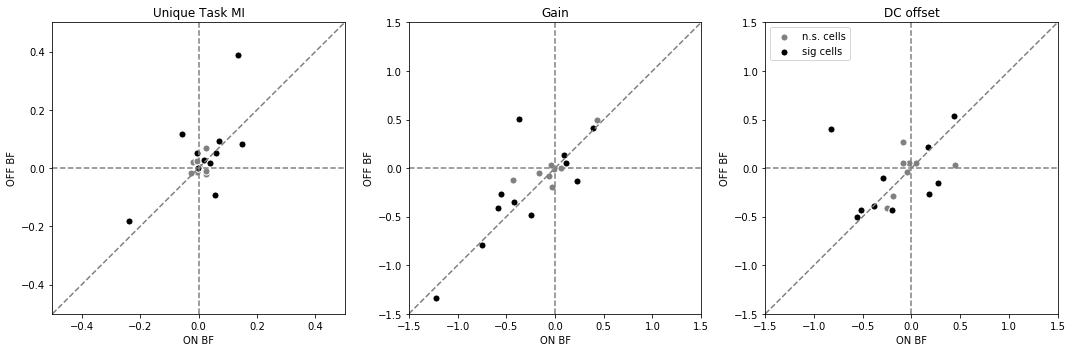

In [10]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))

taskON = df[df.index.isin(matched) & (df.ON_BF)].groupby(by='cellid').mean()
taskOFF = df[df.index.isin(matched) & (df.OFF_BF)].groupby(by='cellid').mean()

ax[0].set_title('Unique Task MI')
ax[0].scatter(taskON['MI_task'], taskOFF['MI_task'], color='grey', edgecolor='white', s=50)
ax[0].scatter(taskON[taskON.sig_task]['MI_task'], 
                taskOFF[taskOFF.sig_task]['MI_task'], color='k', edgecolor='white', s=50)
ax[0].plot([-1, 1], [-1, 1], 'grey', linestyle='--')
ax[0].axhline(0, linestyle='--', color='grey')
ax[0].axvline(0, linestyle='--', color='grey')
ax[0].set_xlim((-.5, .5))
ax[0].set_ylim((-.5, .5))
ax[0].set_xlabel('ON BF')
ax[0].set_ylabel('OFF BF')

if not sdexp:
    axlim = 1.5
else:
    axlim = 10
ax[1].set_title('Gain')
ax[1].scatter(taskON['gain_task'], taskOFF['gain_task'], color='grey', edgecolor='white', s=50)
ax[1].scatter(taskON[taskON.sig_task]['gain_task'], 
                taskOFF[taskOFF.sig_task]['gain_task'], color='k', edgecolor='white', s=50)
ax[1].plot([-axlim, axlim], [-axlim, axlim], 'grey', linestyle='--')
ax[1].axhline(0, linestyle='--', color='grey')
ax[1].axvline(0, linestyle='--', color='grey')
ax[1].set_xlim((-axlim, axlim))
ax[1].set_ylim((-axlim, axlim))
ax[1].set_xlabel('ON BF')
ax[1].set_ylabel('OFF BF')

ax[2].set_title('DC offset')
ax[2].scatter(taskON['dc_task'], taskOFF['dc_task'], color='grey', edgecolor='white', s=50, label='n.s. cells')
ax[2].scatter(taskON[taskON.sig_task]['dc_task'], 
                taskOFF[taskOFF.sig_task]['dc_task'], color='k', edgecolor='white', s=50, label='sig cells')
ax[2].plot([-axlim, axlim], [-axlim, axlim], 'grey', linestyle='--')
ax[2].axhline(0, linestyle='--', color='grey')
ax[2].axvline(0, linestyle='--', color='grey')
ax[2].legend()
ax[2].set_xlim((-axlim, axlim))
ax[2].set_ylim((-axlim, axlim))
ax[2].set_xlabel('ON BF')
ax[2].set_ylabel('OFF BF')

f.tight_layout()


### PUPIL modulation

The above analysis doesn't apply to pupil, because target freq. isn't dependent on pupil state